# Face Occlusion in the Wild
## Introduction
어플리케이션 사용자가 촬영한 얼굴은 소정의 과정을 거쳐 서버로 업로드된다. 업로드된 사용자의 얼굴은 인증용도로 활용할 수 있는데, 인증용도로 사용하기 적합하지 않은 사진은 단말단에서 미리 필터하여 사용자에게 해당 촬영본은 인증용도로 사용할 수 없음을 고지하고 재촬영을 유도하면 서비스의 품질 향상에 기여할 수 있을 것이다. 이에 더해 촬영한 사진에서 어떤 부위가 가려졌는지를 안내할 수 있다면 재촬영시 사용자의 수고를 덜어줄 수 있을 것이다.

이를 위해 얼굴의 가림 유무를 판단할 수 있는 데이터셋을 활용하여 이미지 분류 모델을 학습한다면 좋을 것이다. 분류 기준은 크게는 얼굴의 가림 유무를 판단하는 단계와 가려졌다면 상관, 하관 혹은 양측 모두 가림이 존재하는지를 판단하는 단계로 나눌 수 있다. 각각의 단계를 분리하여 cascade 형태의 모델로 설계할 수 있고, 하나의 모델에서 모두 처리할 수도 있다. Cascade 형태의 모델은 각각의 모델이 매우 높은 성능을 가져야 하고, 이 성능 향상이 복수의 모델을 사용하는데 있어 소요되는 latency 손실을 충분히 감당할 수 있을 만큼이어야 사용자와 프로젝트 관계자들을 설득할 수 있다. 따라서 주된 설계방향은 단일 모델에서 처리하는 것으로 하되, cascade 형태의 모델성능은 보충자료로 기록한다.

## EDA
학습에 앞서 해당 데이터셋의 클래스 밸런스를 확인하는 것은 분류문제를 푸는데 있어 매우 중요하다. 밸런스가 맞지 않는 데이터셋의 경우 학습시에 다수를 차지하는 클래스에 적합하는 것이 정확도 지표상으로 유리하고 실제로 모델의 학습도 그러한 방식으로 진행되기 때문이다. 

In [2]:
import os
from collections import defaultdict

import pandas as pd
from PIL import Image
from utils import get_labels

%matplotlib inline

.DS_Store is not an image.
.ipynb_checkpoints is not an image.


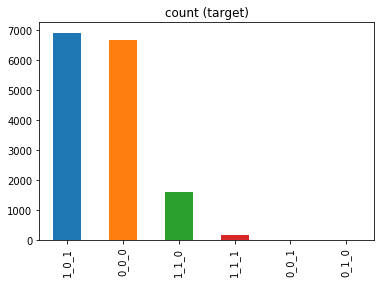

In [3]:
df = pd.DataFrame.from_dict(get_labels())
df['class'].value_counts().plot(kind='bar', title='count (target)')

위의 그림과 같이 일부 클래스의 경우 다른 클래스에 비해 정량적 갯수가 매우 부족함을 알 수 있다. 또한 일부 클래스의 경우 전체 얼굴의 가림이 없으나 하관 혹은 상관의 가림이 있다고 잘못 기록한 경우도 존재함을 확인할 수 있다. 이에 해당하는 2 개의 클래스는 노이즈로 간주하고 삭제하였다. 따라서 최종적인 모델링에 사용할 클래스는 4 개로 지정하였다.

## Methods
모델은 [1] MobileFaceNets 를 선정하였다. MobileNet V2 기반의 모델인 해당 모델은 얼굴 인식에 있어 기존 MobileNet V2 모델보다 강점을 보이는 모델이다. 두 모델간의 주요한 차이는 다음과 같다. 일반적으로 backbone 단에서 feature pooling 을 진행할 때, 일반적으로 global average pooling 을 진행하는데, 이러한 방식이면 이미지의 가장자리의 feature 까지 모두 동일한 중요도로 간주한다. 일반적으로 얼굴에 중점을 둔 이미지는 중앙에 중요한 feature 가 존재할 가능성이 많으므로 해당 방식보다는 [3] global depthwise convolution 을 적용하여 각 feature 의 position 별로 중요도를 학습하는 방식이 더 유리함이 실험적으로 증명되어 있다. 따라서 MobileFaceNets 는 이러한 방식을 차용하여 성능향상에 기여한다. 해당 모델을 바로 사용하는 것 보다는 [2] InsightFace 데이터에 사전학습 이후에 주어진 데이터셋에 적합하면 성능상 매우 큰 이점을 가져올 수 있다.

In [2]:
import io
import torch
import matplotlib.pyplot as plt
import contextlib

from torchvision import transforms as trans

from config import get_config
from Learner import face_learner
from data.data_pipe import get_val_data

In [3]:
with contextlib.redirect_stdout(io.StringIO()):
    conf = get_config(training=True)
    conf.use_mobilfacenet = True
    learner = face_learner(conf, inference=False)

    checkpoint = torch.load("/workspace/InsightFace_Pytorch/work_space/save/model_2022-08-05-22-09_accuracy:0.939209726443769_step:759_final.pth")
    learner.load_state_dict(checkpoint)

이에 더하여 앞서 언급한 클래스 불균형 문제를 해결하기 위해 사용한 방법론을 소개한다. 일반적으로 클래스 불균형 문제에 사용할 수 있는 가장 간단한 해법은 Over-sampling 을 적용하는 것이다. 이미지 수가 부족한 데이터를 의도적으로 더 많이 학습에 노출함으로 손실함수가 특정 클래스에 과적합하는 것을 방지하는 방식이다. 이에 더해 [4] Focal 손실함수를 적용하여 학습하기 어려운 케이스에 더 가중치를 주는 방식으로 학습을 진행하였다.

마지막으로 데이터 전처리 시에 결정 경계를 명확하게 하기 위해서 가림이 일어난 부위를 제외한 나머지 부분을 삭제하였다. 이는 학습 시에 모델이 가림이 일어나지 않은 부분에서 특징을 찾으려는 경향을 방지하기 위함이다. 이 결과 모델의 정확도가 90.8 % 에서 93.9 % 로 상승하였다.

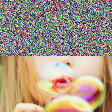

In [4]:
Image.open("data/facebank/train_v2/1_0_1/cropped_1_0_11_COFW_test_30.jpg")

## Experiments
해당 방법론들을 적용한 결과를 소개한다. 먼저 데이터셋을 10-fold 로 나누어 cross validation 을 수행하였다. 성능 지표는 1 차적으로는 accuracy 를 사용하였지만, 데이터 불균형이 있는 문제는 단순히 accuracy 지표로 그 성능을 판단할 수 없기에 confusion matrix 를 성능 확인을 위한 추가 지표로 활용하였다.

facebank loader generated


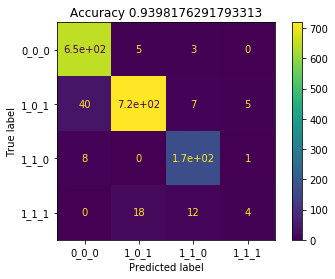

In [5]:
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score
)

y_true, y_pred = learner.test(conf, get_val_data(conf)[0])

cm = confusion_matrix(y_true, y_pred)
accuracy = accuracy_score(y_true, y_pred)

cm_display = ConfusionMatrixDisplay(cm, display_labels=learner.loader.dataset.classes).plot()
plt.title(f'Accuracy {accuracy}')
plt.show()

도시한 바와 같이 가림이 일어나지 않은 이미지에 대해, 가림이 일어났다고 예측할 확률은 적은 것을 알 수 있다. 하지만 가림이 있는 이미지에 대해 가림이 없다고 예측할 확률은 상대적으로 높은 것을 확인할 수 있다. 이에 해당 오류에 대한 질적분석을 수행하였다.

facebank loader generated


/usr/local/lib/python3.7/dist-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


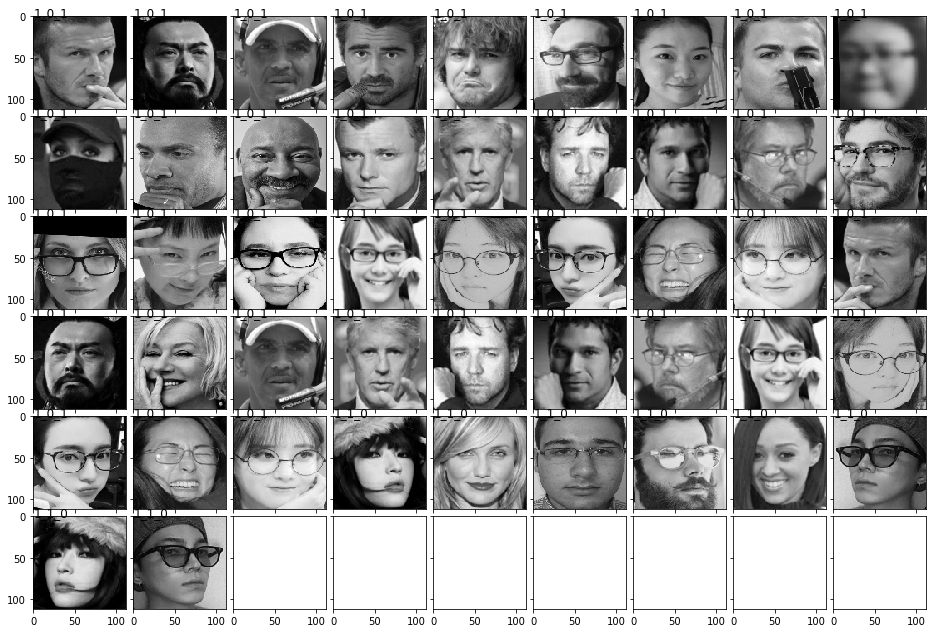

In [6]:
import csv
import numpy as np

from mpl_toolkits.axes_grid1 import ImageGrid
from utils import get_hazardous_samples

hazardous = get_hazardous_samples(learner, conf)

fig = plt.figure(figsize=(16., 16.))
grid = ImageGrid(
    fig, 111,  # similar to subplot(111)
    nrows_ncols=(6, 9),  # creates 2x2 grid of axes
    axes_pad=0.1,  # pad between axes in inch.
)

for idx, sample in enumerate(hazardous):
    image, gt = sample[0], learner.val_loader.dataset.classes[int(sample[1])]
    image = Image.fromarray(image.astype(np.uint8))
    grid[idx].imshow(np.asarray(image.convert('RGB')))
    grid[idx].text(0, 0, gt, fontsize=12)
    
fig.show()

하관 영역 가림의 경우 대부분 턱 부위의 가림 유무를 모델이 잘 판단하지 못한다. 하관 가림의 경우 데이터셋의 구성 중 다수의 이미지들이 마스크를 착용한 경우가 많기 때문으로 볼 수 있다. 상관 가림의 경우 머리카락이 안구 영역을 가렸는지에 대해 잘 판단하지 못하는 모습을 볼 수 있다. 이 외에 이미지들 중 실질적으로는 가림이 없다라고 판단할 수 있는 이미지들도 있다.

### Ablation Study
모델 성능 향상에 주요한 영향을 준 요소는 크게 3 가지로, [2] InsightFace 데이터셋에 모델 사전학습, [4] 클래스 불균형 해결 그리고 가림 영역에 대한 data augmentation 을 들 수 있다. 각기 요소에 대해 얼마나 모델 성능에 영향을 가했는지 판단하기 위해 독립적인 실험을 실시하였다.

| Scratch | Pretraining | Pretraining + Class Imbalance | Pretraining + Class Imbalance + Data Augmentation | 
|---------|------------- |-------------------------------|---------------------------------------------------|
| 0.468   | 0.469       | 0.908                         | 0.939                                             |

[2] InsightFace 데이터셋 사전학습과 [4] 클래스 임밸런스 해결을 동시에 수행하였을 때 1 차적으로 큰 폭의 성능향상이 있었다. 이에 더해 data augmentation 까지 가미하였을 때 추가적인 성능 향상이 존재했다.

## Conclusion and Future Works
본 문서에서는 얼굴 가림 여부를 분류하는 모델을 작성하고 높은 성능을 달성하는 방법을 제안하였다. 실험 결과 얼굴 가림 유무를 판단하는데 있어 도움이 될 수 있는 모델인 것을 증명하였다. 다만 실험 결과 일부 이미지들의 경우 가림이 존재하지만 모델 추론을 하였을 때 가림이 없다라고 판단하는 경우가 존재하였다. 각각의 케이스들을 분석하였을 때, 학습 데이터에 오류 케이스를 유발하는 요소들(머리 스타일, 턱 가림 등등)을 추가할 수 있다면 학습 성능향상에 크게 도움이 될 것이다. 이를 위해 [5] 합성 이미지 생성 기술을 활용하여 데이터를 추가하여 성능 향상을 도모할 수 있을 것이다.

## Reference
[1] Chen, S., Liu, Y., Gao, X., & Han, Z. (2018). MobileFaceNets: Efficient CNNs for Accurate Real-time Face Verification on Mobile Devices. ArXiv, abs/1804.07573.  
[2] Jia Guo. (2021). InsightFace datasets  . Retrieved 08/05, 2022, from https://github.com/deepinsight/insightface/wiki/Dataset-Zoo   
[3] Chollet, F.: Xception: Deep learning with depthwise separable convolutions. arXiv preprint, arXiv:1610.02357 (2016)   
[4] Lin, T., Goyal, P., Girshick, R.B., He, K., & Dollár, P. (2017). Focal Loss for Dense Object Detection. 2017 IEEE International Conference on Computer Vision (ICCV), 2999-3007.   
[5] Voo, K.T., Jiang, L., & Loy, C.C. (2022). Delving into High-Quality Synthetic Face Occlusion Segmentation Datasets. ArXiv, abs/2205.06218.   

## Supplementary Material
Cascade 형태의 설계가 어떠한 이점 혹은 한계점을 가지는지에 대해 분석한다. 해당 모델을 학습하기 위해 전체 데이터셋을 가림 여부만 판단하는 이진 분류 데이터셋으로 재구성하였다. 아래는 해당 모델의 정확도와 confusion matrix 이다.

In [2]:
with contextlib.redirect_stdout(io.StringIO()):
    conf = get_config(training=True)
    conf.use_mobilfacenet = True
    learner = face_learner(conf, inference=False)

    checkpoint = torch.load("/workspace/InsightFace_Pytorch/work_space/save/model_2022-08-06-17-17_accuracy:0.9595035924232528_step:162_final.pth")
    learner.load_state_dict(checkpoint)

facebank loader generated


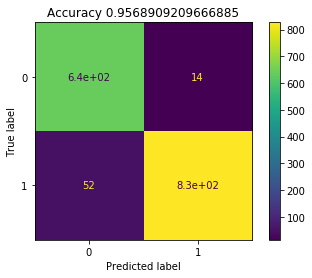

In [3]:
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score
)

y_true, y_pred = learner.test(conf, get_val_data(conf)[0])

cm = confusion_matrix(y_true, y_pred)
accuracy = accuracy_score(y_true, y_pred)

cm_display = ConfusionMatrixDisplay(cm, display_labels=learner.loader.dataset.classes).plot()
plt.title(f'Accuracy {accuracy}')
plt.show()

기존 모델에 대비해 큰 성능상 이점이 없는 것을 확인할 수 있다.